In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
    datasets,
)
import pickle
import tensorflow.keras.backend as K
import tensorboard as tb
from model import GAN
import librosa as lb
from preprocess import load_raw_audio
from preprocess import denormalise
from IPython.lib.display import Audio
import IPython
import pandas as pd
import json

import scipy.signal
from scipy.fft import fft
from scipy.signal import spectrogram
from utils import *
from keras.utils.vis_utils import plot_model

In [26]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

model_directory ="C:/Users/Jayde/Desktop/wavegan/models_1212.1053"
model_directory = newest("C:/Users/Jayde/Desktop/wavegan/")
print(model_directory)
spec_path = f"{model_directory}/model_specifications.json"
with open(spec_path, 'r') as f:
  specs = json.load(f)

C:/Users/Jayde/Desktop/wavegan/models_1512.1830


In [27]:
gan = GAN(
    latent_dim = specs["Latent Dim"],
    discriminator_steps= specs["Discriminator Steps"],
    gp_weight= specs["GP Weight"],
    n_categories= specs["N Categories"],
    slice_len=16384,
)

In [ ]:
plot_model(generator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 16, 1024)          0         
                                                                 
 re_lu (ReLU)                (None, 16, 1024)          0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 512)          13107712  
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 64, 512)           0         
                                                         

In [30]:
tf.keras.backend.random_bernoulli([5,5],0.5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 1.],
       [0., 1., 1., 1., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [42]:
generator = gan.generator
generator.load_weights(f"{model_directory}/generator5000")

In [7]:
disc = gan.discriminator
disc.load_weights(f"{model_directory}/discriminator")

aux = gan.auxiliary
aux.load_weights(f"{model_directory}/auxiliary")

In [45]:
df = pd.DataFrame()
doses = []
bits = []
fundamental_freqs = []
f0_stds = []
sr = 16000
for dose in range(-1, 13):
    inputs = create_inputs(specs, 250, bit_value = dose, baseline_dose = 0)
    for bit,input in enumerate(inputs):
        generated = generate_samples(generator,input,model_directory)

        f0, f0_std = avg_fundamental_freq(generated, sr = sr)
        doses.append(dose)
        bits.append(bit)
        fundamental_freqs.append(f0)
        f0_stds.append(f0_std)

df['bit'] = bits
df['dose'] = doses
df['f0'] = fundamental_freqs
df['f0 std'] = f0_stds
df.to_csv("Bits.csv", index= False)


8/8 [==============================] - 17s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 16s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 17s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 16s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 15s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 16s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 16s 2s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED
8/8 [==============================] - 16

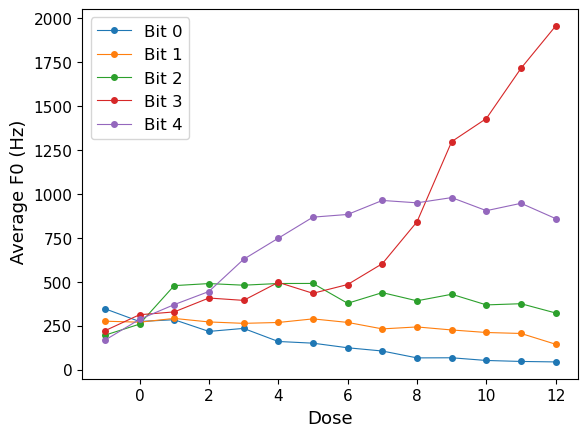

In [51]:
for bit in range(specs["N Categories"]):
    bit_data = df.loc[df['bit'] ==bit]
    plt.plot(bit_data['dose'], bit_data['f0'], '-o', markersize = 4,linewidth =0.8, label = f"Bit {bit}")
    #plt.errorbar(bit_data['dose'], bit_data['f0'], yerr=bit_data['f0 std dev'], marker = 'o',markersize = 4,linewidth =0.8, label = f"Bit {bit}")
plt.xlabel("Dose", fontsize = 13)
plt.ylabel(" Average F0 (Hz)", fontsize = 13)
plt.legend(fontsize =12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
#plt.ylim(0,3000)
plt.savefig("F0_bits.png", dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()

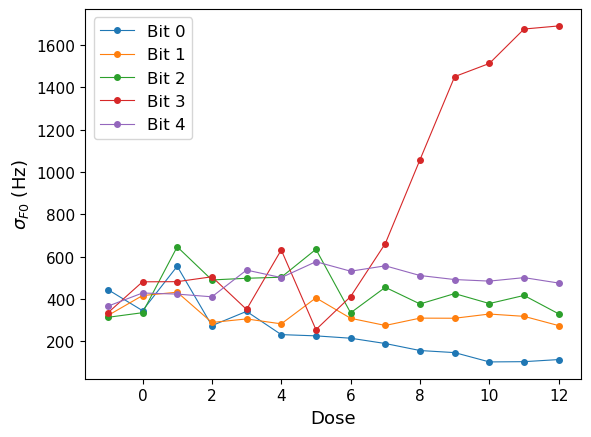

In [53]:
for bit in range(specs["N Categories"]):
    bit_data = df.loc[df['bit'] ==bit]
    plt.plot(bit_data['dose'], bit_data['f0 std'], '-o', markersize = 4,linewidth =0.8, label = f"Bit {bit}")
    #plt.errorbar(bit_data['dose'], bit_data['f0'], yerr=bit_data['f0 std dev'], marker = 'o',markersize = 4,linewidth =0.8, label = f"Bit {bit}")
plt.xlabel("Dose", fontsize = 13)
plt.ylabel("$\sigma_{F0}$ (Hz)", fontsize = 13)
plt.legend(fontsize = 12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.savefig("F0_st_dev_bits.png", dpi= 300, bbox_inches = "tight", transparent = True)
#plt.ylim(0,3000)
plt.show()

In [40]:
inputs = create_inputs(specs,15,bit_value= 1, random =True)
outputs=[]
for input in inputs:
    generated_audio = generator.predict(input) 
    generated_audio= np.squeeze(generated_audio)
    #print(generated_audio.shape)
    audio = denormalise(generated_audio,f"{model_directory}/normaliser_values")
    outputs.append(audio)


Random c
1/1 [==============================] - 1s 1s/step
DENORMALISING- MEAN:-0.00011045925930375233, STD_DEV:0.07974209636449814
DENORMALISED


In [41]:
code_1 = outputs[0]
sr = 16000
for audio in code_1:
    IPython.display.display(Audio(audio, rate =sr))

Fundamental Frequency- 312.5 Hz


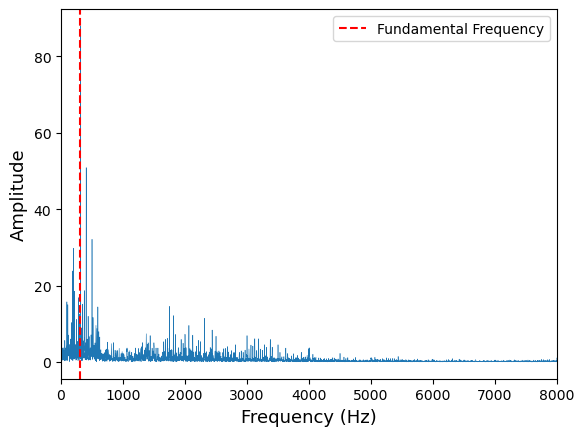

In [23]:
save_dir = "C:/Users/Jayde/Dropbox/decoding-animimal-communication/figures/nine_graphs.png"
signal =code_1[6]
#create_plots(signal, sr, window_length=768)
create_fft(signal,sr)

In [8]:
file_path = "C:/Users/Jayde/Desktop/Datasets/sc09/sc09/nine/0a2b400e_nohash_2.wav"
signal, sr = lb.load(file_path, sr = 16000)
print(sr)
IPython.display.display(Audio(signal, rate =sr))

16000


c:\Users\Jayde\Dropbox\decoding-animimal-communication\winfoGAN\utils.py:102: RuntimeWarning: divide by zero encountered in log10
  axs[i].pcolormesh(t_bins, f_bins, 20*np.log10(Sxx+1e-100), cmap='magma')


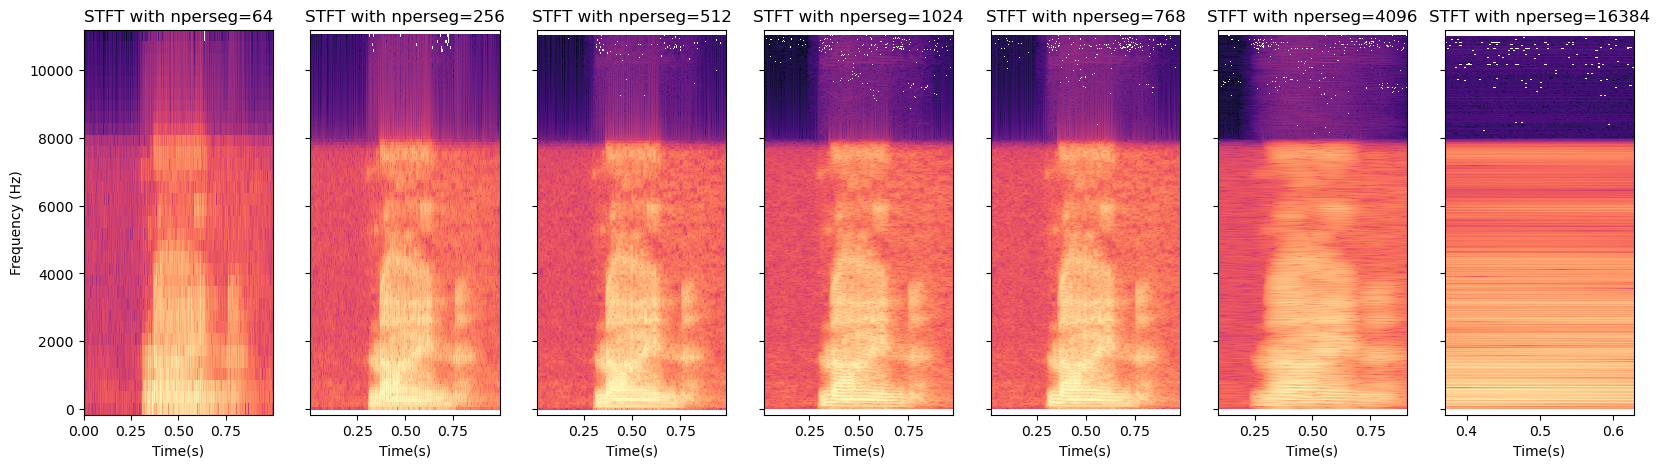

In [35]:
window_lengths(signal,sr)

In [ ]:
from scipy.io.wavfile import write
write("example_audio4.wav", sr, audio_1)

In [14]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [32]:
event_file = os.listdir(f"{model_directory}/logs/train")[0]
event_file = f"{model_directory}/logs/train/{event_file}"

In [33]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import struct
g_loss=[]
d_loss =[]
d_gp=[]
d_w_loss=[]
q_loss =[]
steps=[]
for e in summary_iterator(event_file):    
    for v in e.summary.value:
        if v.tag == 'epoch_g_loss':            
            g_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_loss':            
            d_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])
        
        elif v.tag == 'epoch_d_gp':            
            d_gp.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_d_wass_loss':            
            d_w_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

        elif v.tag == 'epoch_q_loss':            
            q_loss.append(struct.unpack('f', v.tensor.tensor_content)[0])

In [34]:
lr = specs["Learning Rate"]
specs_str = '\n'.join((
    r'Batch Size = %.f' % (specs["Batch Size"], ),
    r'Training Size = %.f' % (specs["Training Size"],),
    r'Discriminator Steps = %.f' % (specs["Discriminator Steps"], ),
    f"Learning Rate = {lr}"))
specs_str

'Batch Size = 64\nTraining Size = 1280\nDiscriminator Steps = 5\nLearning Rate = 5e-05'

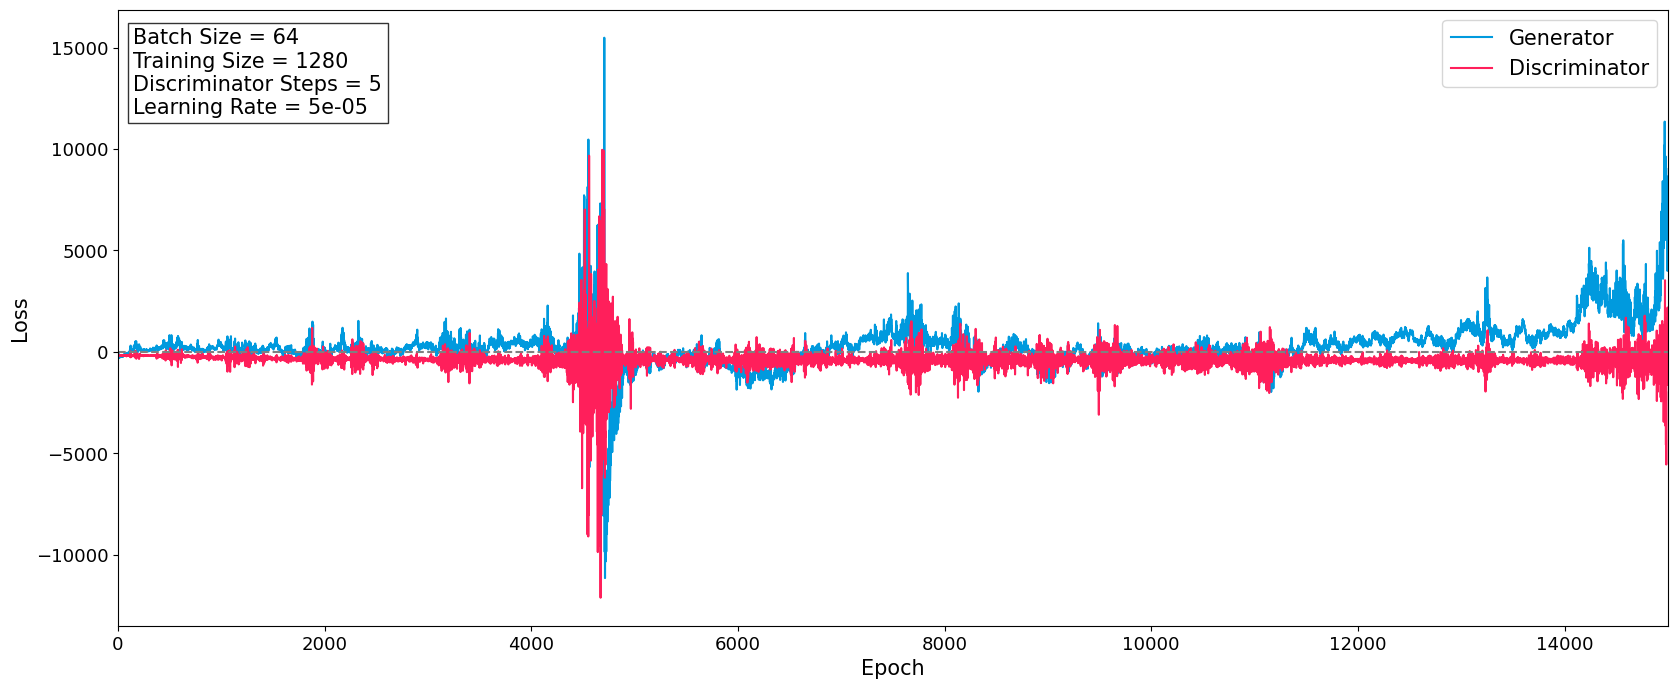

In [35]:
#plt.style.use('seaborn-pastel')
plt.figure(figsize=(20,8))
plt.plot(g_loss, label = "Generator", color = '#009ade')
plt.plot(d_loss, label = "Discriminator", color = '#ff1f5b')
plt.legend(fontsize= 15)
plt.xlim(0,len(g_loss))
plt.xlabel("Epoch", fontsize= 15)
plt.ylabel("Loss", fontsize= 15)
plt.xticks(fontsize= 13)
plt.yticks(fontsize= 13)
plt.axhline(y=0, color = "grey", linestyle = "dashed")

plt.text(0.01, 0.97, specs_str, transform=plt.gca().transAxes, fontsize=15,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()


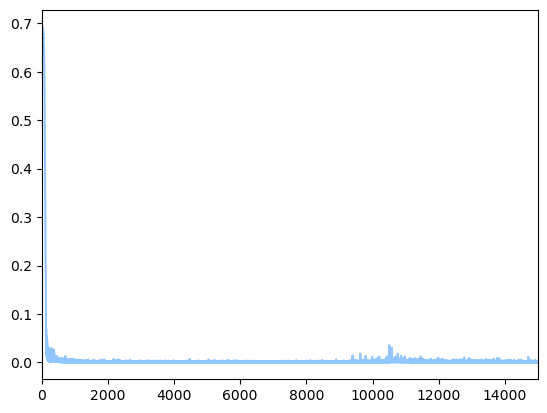

In [16]:
plt.plot(q_loss)
plt.xlim(0,15000)
plt.show()


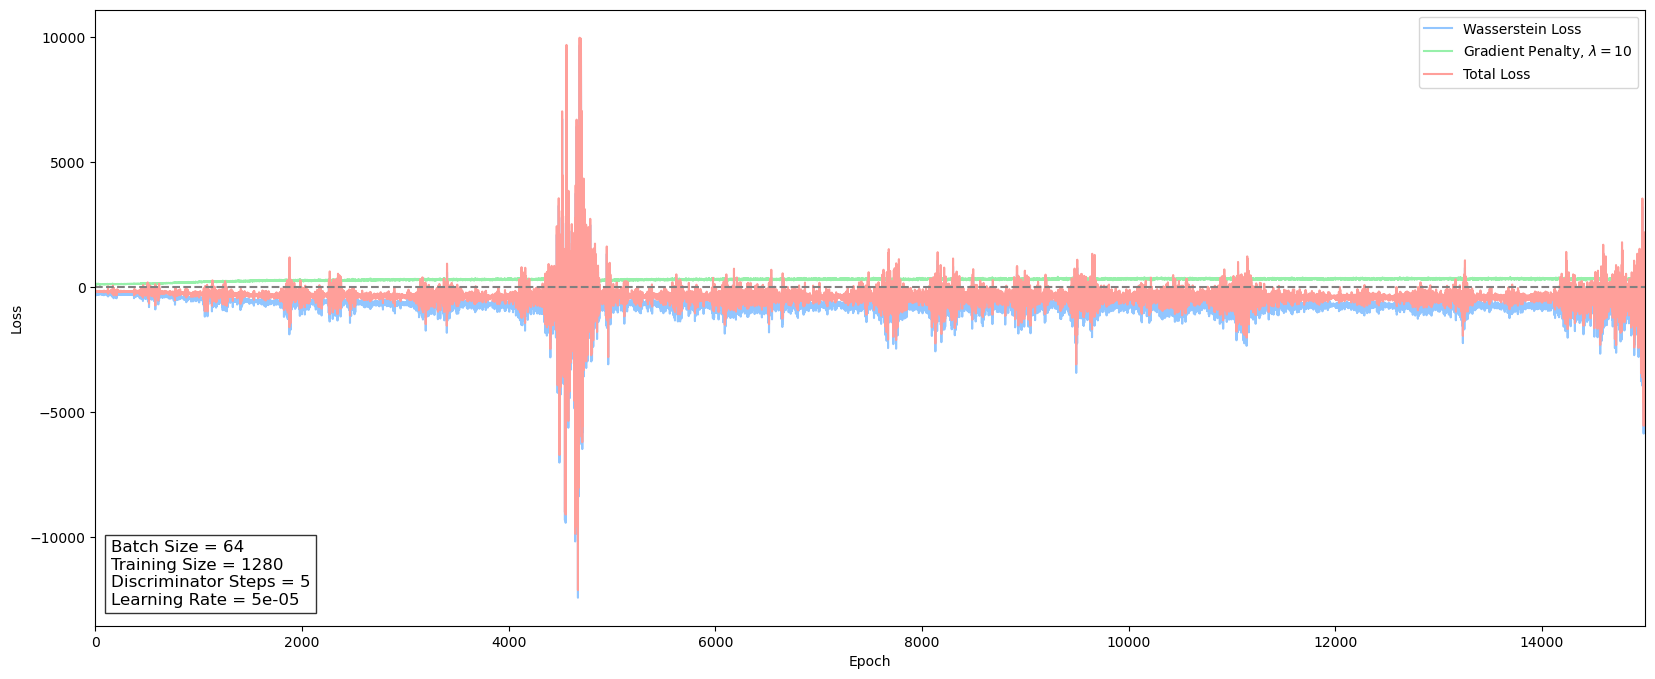

In [16]:
gp_weight = specs["GP Weight"]
plt.figure(figsize=(20,8))
plt.plot(d_w_loss, label = "Wasserstein Loss")
plt.plot(np.array(d_gp)*gp_weight, label = f"Gradient Penalty, $\lambda = {gp_weight}$")
plt.plot(d_loss, label = "Total Loss")
plt.legend()
plt.xlim(0,len(d_loss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.axhline(y=0, color = "grey", linestyle = "dashed")

plt.text(0.01, 0.03, specs_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))

fig_dir = f"{model_directory}/discriminator_loss_graph.png"
plt.savefig(fig_dir, dpi= 300, bbox_inches = "tight", transparent = True)
plt.show()